# Get data for points of interest (POIs) to estimate attraction for each zone

There are two ways of fetching data from OpenStreetmap:
* Using overpass queries
* Using locally saved osm.pbf file

Overpass queries take a long time, but work without any further packages. The faster version requires downloading a pbf file for the region of Germany. This is available here (should be saved under `input_static`: https://download.geofabrik.de/europe.html

In [211]:
import os.path
pbf_file_path = '../input_static/berlin-latest.osm.pbf'
use_queries = not os.path.exists(pbf_file_path)

In [212]:
import pandas as pd
import geopandas as gpd
import numpy as np
from quetzal.model import stepmodel
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

from pyrosm import OSM, get_data

# Disable deprectation warnings caused by libraries
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline

In [213]:
# import helper functions
%run -i helperFunctions.py

In [214]:
model_path = '../model/'
input_path = '../input/'

# Number of POIs from OSM data

The extraction from OpenStreetmap makes use of Overpass querys (for documentation see http://osmlab.github.io/learnoverpass/en/docs/). <br>
For trying out querys and their results, use https://overpass-turbo.eu/ (although a success in overpass turbo does not always imply a success in my request). 

For documentation of OpenStreetMap data, see OSM Wiki: https://wiki.openstreetmap.org/.

In [215]:
sm = stepmodel.read_json(model_path + 'ber_zones')

<AxesSubplot:>

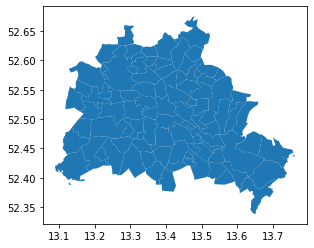

In [216]:
sm.zones = gpd.GeoDataFrame(sm.zones)
sm.zones.plot()

In [219]:
# Load POI code Excel
poi_codes = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx')

In [220]:
poi_codes.head(3)

,Wert MiD,purpose model,Wertelabel ausfuehrlich,key,value,weight,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1.0,commuting,Erreichen des Arbeitsplatzes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,business,dienstlich/geschäftlich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,education,Erreichen der Ausbildungsstätte/Schule,amenity,college,large,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
poiKeyVals = poi_codes.loc[(poi_codes['key'].notna()), ['key', 'value']].values
poiKeyVals[0]

array(['amenity', 'college'], dtype=object)

In [239]:
poi_codes.loc[(poi_codes['key'].notna()), ['key', 'value']].values[5]

array(['craft', nan], dtype=object)

In [224]:
poi_codes.loc[(poi_codes['key'].notna())&(poi_codes['value'].isna()), 'key']

7    craft
Name: key, dtype: object

## set up new OSM to avoid erorrs when trying to extract POIs

In [225]:
fpb = get_data("Berlin", update=True)
osmb = OSM(fpb)

Downloaded Protobuf data 'Berlin.osm.pbf' (86.55 MB) to:
'C:\Users\BSE\AppData\Local\Temp\pyrosm\Berlin.osm.pbf'


In [226]:
poiKeys = list(filter(lambda x: x == x, poi_codes['key'].unique()))

In [227]:
poiVals = list(filter(lambda x: x == x, poi_codes['value'].unique()))

In [228]:
poiKeys

['amenity', 'building', 'craft', 'shop', 'leisure', 'tourism', 'water']

### extract POIS from OSM

In [229]:
# custom filter set up:
#   for each unique key
#      filter all values

#      add column "key" fill in key 
#   .


In [230]:
# prepare a list to store dataframes for each query 
pois_arr = []
# get pois data for each key
for key in poiKeys:
    # get all search values for key
    valuesForKey = list(filter(lambda x: x[0] == key, poiKeyVals))
    # if value is NaN, put True (which is the case for key="craft") instead of NaN
    valuesForKey = list(map(lambda x: x[1] if x[1]==x[1] else True, valuesForKey))
    # custom_filter will get all pois with the key and one of the values in valuesForKey
    custom_filter = {key: valuesForKey}
    print(key)
    # get_pois from OSM
    poisForKey = osmb.get_pois(custom_filter=custom_filter)
    # rename column to store value
    poisForKey.rename(columns = { key: 'value' }, inplace = True)
    # create column named key and store the key to
    poisForKey['key'] = key
    # only keep necessary columns
    if not 'value' in poisForKey:
        print("for ", key, "values are", valuesForKey, "values column was missing. Colnames: ", list(poisForKey))
        poisForKey['value'] = valuesForKey[0]

    poisForKey = poisForKey[['key', 'value', 'geometry']]
    # append to df for all keys
    print(poisForKey.head(2))
    pois_arr.append(poisForKey)

# merge pois to one dataframe
pois = pd.concat(pois_arr)
pois.index = range(len(pois.index))
# set crs code correctly
pois = pois.to_crs(epsg = crs_code)

amenity
       key       value                   geometry
0  amenity  restaurant  POINT (13.32282 52.50691)
1  amenity  restaurant  POINT (13.31808 52.50621)
building
        key   value                                           geometry
0  building  school                          POINT (13.33420 52.75945)
1  building  retail  POLYGON ((13.33907 52.52743, 13.33903 52.52741...
craft
     key     value                   geometry
0  craft  cleaning  POINT (13.32458 52.47364)
1  craft   caterer  POINT (13.11071 52.39381)
shop
    key        value                   geometry
0  shop  supermarket  POINT (13.40737 52.50982)
1  shop       bakery  POINT (13.40830 52.51036)
leisure
       key         value                   geometry
0  leisure  beach_resort  POINT (13.55639 52.76102)
1  leisure         pitch  POINT (13.31927 52.49055)
tourism
       key   value                   geometry
0  tourism  hostel  POINT (13.48645 52.80360)
1  tourism   hotel  POINT (13.32925 52.52328)
water
for  water 

In [244]:
len(pois["value"].unique())

181

In [261]:
pois.iloc[list(map(lambda x: x in poiVals, list(pois["value"])))]

,key,value,geometry
0,amenity,restaurant,POINT (19453.811 20020.430)
1,amenity,restaurant,POINT (19131.587 19943.688)
2,amenity,restaurant,POINT (19315.430 20066.435)
3,amenity,biergarten,POINT (10435.841 11882.293)
4,amenity,biergarten,POINT (9448.084 10411.097)
...,...,...,...
51836,water,lake,"POLYGON ((10206.103 13641.846, 10237.677 13655..."
51837,water,lake,"POLYGON ((16342.582 17879.226, 16329.797 17865..."
51838,water,lake,"POLYGON ((-3813.549 3154.161, -3816.855 3169.3..."
51839,water,lake,"POLYGON ((39061.865 -10719.947, 39073.007 -107..."


Text(0.5, 1.0, 'Inspect all POIs filtered for matching values')

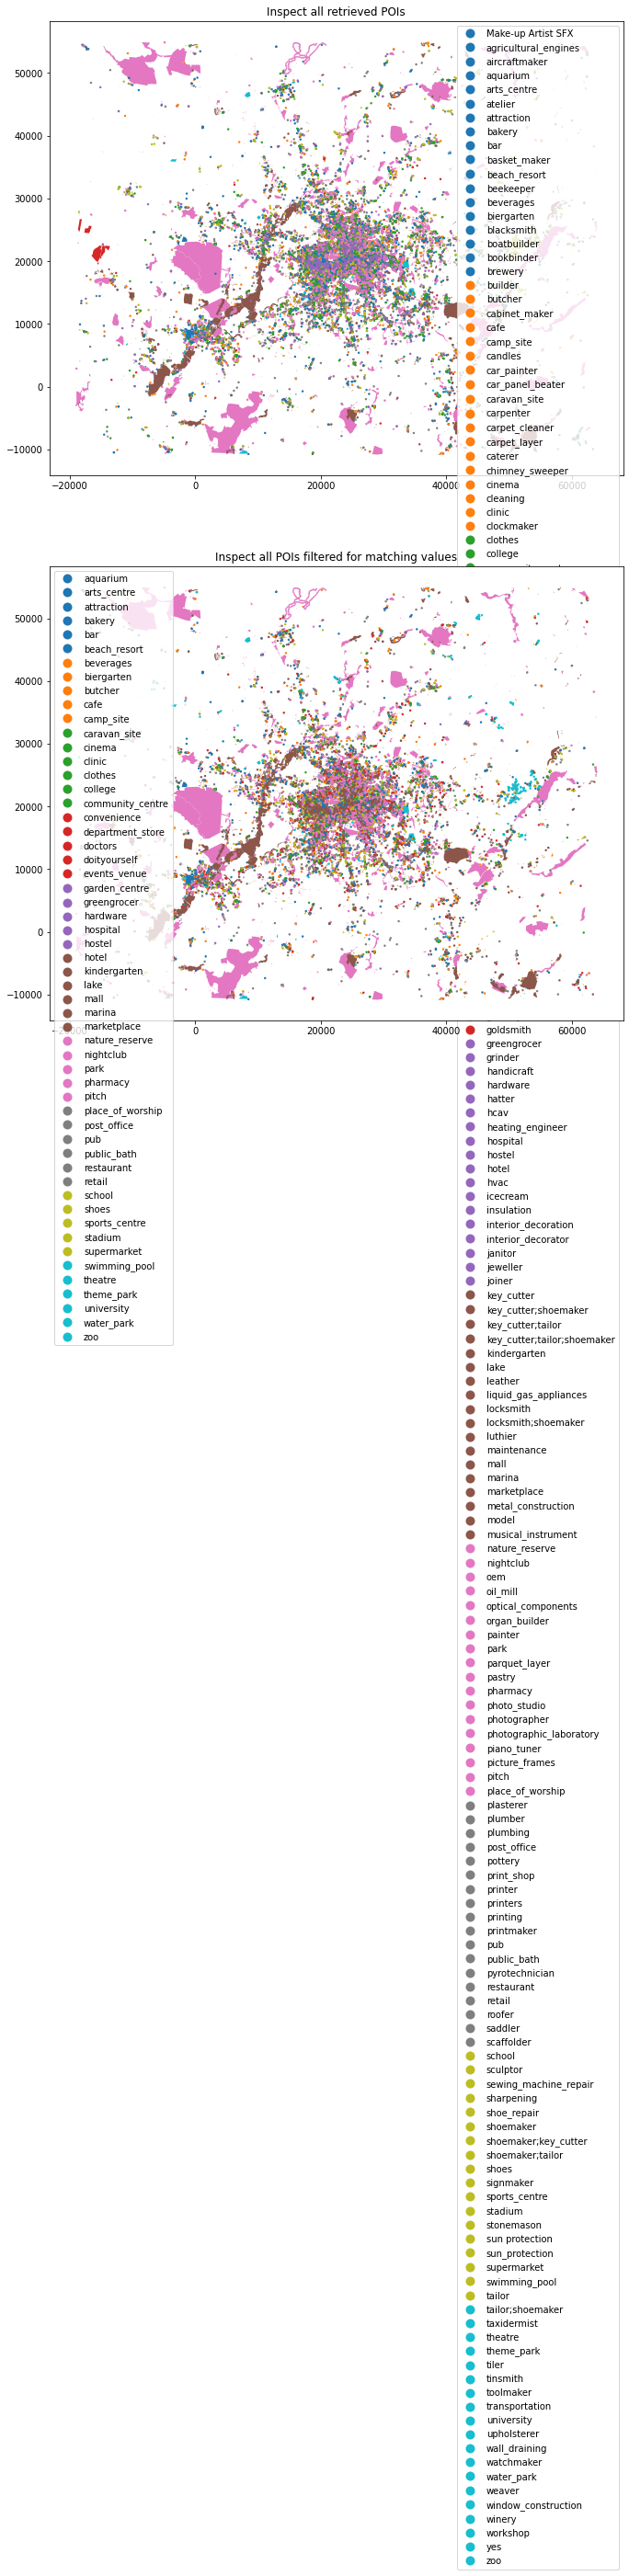

In [271]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
pois.plot(ax = ax.flat[0], column = "value", markersize = 2, legend = True)
pois.iloc[list(map(lambda x: x in poiVals, list(pois["value"])))].plot(ax = ax.flat[1], column = "value", markersize = 2, legend = True)
ax.flat[0].set_title("Inspect all retrieved POIs")
ax.flat[1].set_title("Inspect all POIs filtered for matching values")

# match POI information to zones
- prepare zones dataframe to store information about POIs
- then loop through POIs, check in which zone(s) POI lies and 
- add increase the numbers of POIs in that category in that zone by 1

In [232]:
# assign each amenties to one (Points) or (potentially) multiple zones (Polygons)
# this takes a very long time (about 15:00 mins)
t0 = time.time()
# add columns to geodataframe sm.zones to store ammount of amenities
#   - keys
#   - values
for keyOrValue in (poiKeys + poiVals):
    sm.zones[keyOrValue] = 0
#


for poiIndex, poiRow in pois.iterrows():
    poiGeom = poiRow.geometry
    # if poi geom type is point only look for single intersection 
    if(type(poiGeom) == 'Point'):
        zoneIndex = 0
        # test for each zone whether the amenity lies within. 
        # if so assign amenity to the zone
        while not poiGeom.intersects(zones.iloc[zoneIndex].geometry):
            zoneIndex += 1
            if(zoneIndex > max(zones["zoneIndex"])):
                zoneIndex = -1
                break
        if(zoneIndex >= 0):
            sm.zones.at[zoneIndex, poiRow['key']] += 1
            # necessary as values for craft will not be stored explicitly in sm.zones
            if(poiRow['value'] in sm.zones.columns):
                sm.zones.at[zoneIndex, poiRow['value']] += 1
    # else (poi is polygon) look for multiple intersections with zones 
    else:
        for zoneIndex, zoneRow in sm.zones.iterrows():
            
            if(poiGeom.intersects(zoneRow.geometry)):
                
                sm.zones.at[zoneIndex, poiRow['key']] += 1
                # necessary as values for craft will not be stored explicitly in sm.zones
                if(poiRow['value'] in sm.zones.columns):
                    sm.zones.at[zoneIndex, poiRow['value']] += 1
    
    helpers.printProgress(i=poiIndex, imax=len(pois), t=time.time(), t0=t0, threshold = 0.01)
               
sm.zones.head(3)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 14:32. Minutes remaining: 00:00. 

,uuid,sch,nam,gdf,bezeich,zoneIndex,geometry,amenity,building,craft,...,water_park,aquarium,attraction,camp_site,caravan_site,hostel,hotel,theme_park,zoo,lake
index,,,,,,,,,,,,,,,,,,,,,
0,DEBE04YY5000000B,110000040403,Schmargendorf,3588120.0,AX_KommunalesGebiet,0,"POLYGON ((17534.702 18350.523, 17535.417 18349...",80,27,3,...,0,0,0,0,0,0,2,0,0,0
1,DEBE04YY50000001,110000040405,Westend,13527378.0,AX_KommunalesGebiet,1,"POLYGON ((16638.328 22656.174, 16680.168 22632...",155,103,6,...,0,0,2,0,0,1,13,0,0,3
2,DEBE01YYK0000001,110000010103,Hansaviertel,528303.0,AX_KommunalesGebiet,2,"POLYGON ((20991.303 21748.889, 20998.073 21746...",25,22,1,...,0,0,0,0,0,0,1,0,0,0


## inspect POIs per zone

### For POI keys

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:05. Minutes remaining: 00:00. 

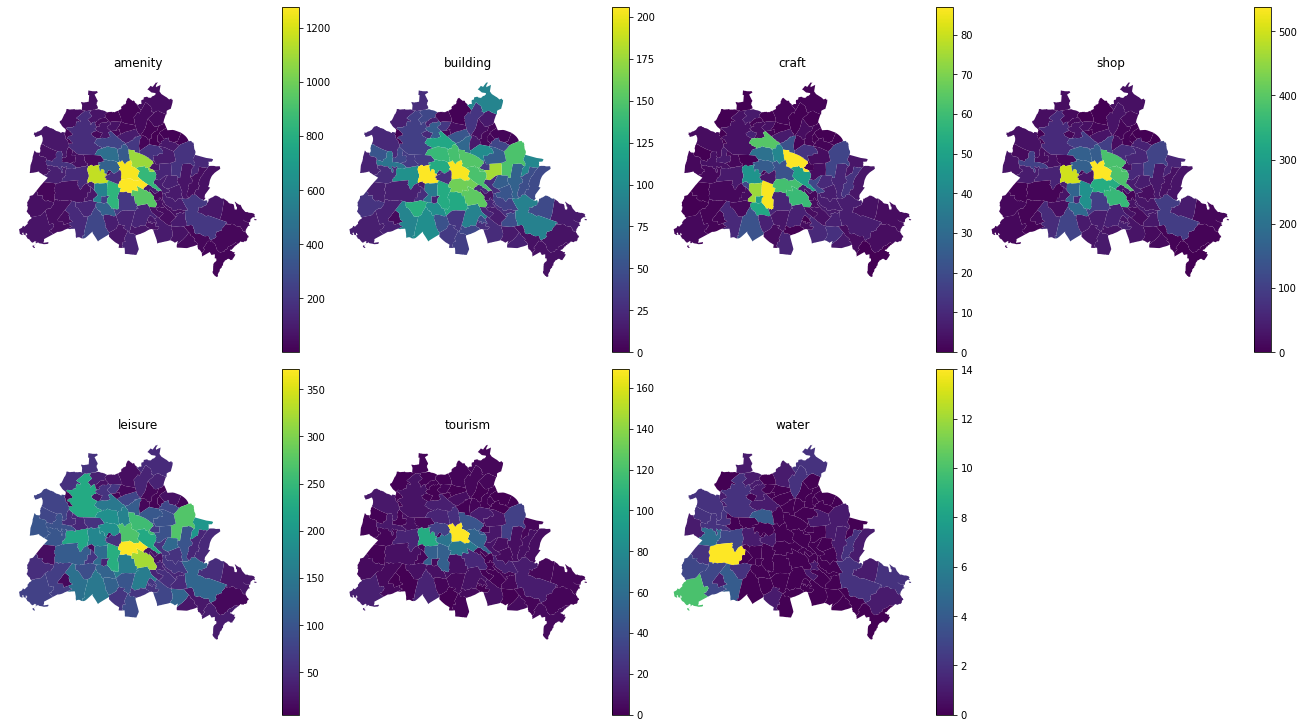

In [233]:
t0=time.time()
# Show maps for keys
clmns = poiKeys
ncols = 4
def ceil (n):
    return(n // 1 + 1 if(n - n // 1) else n)
nrows = int(ceil(len(clmns) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(18,5*nrows), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for ind, clmn in enumerate(clmns):
    sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
    axs.flat[ind].set_axis_off()
    axs.flat[ind].set_title(clmn)
    helper["printProgress"](i=ind, imax=len(clmns), t=time.time(), t0=t0)

## remove empty plots
for ax in axs.flat:
    ## check if something was plotted 
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

### For POI values

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 04:20. Minutes remaining: 00:00. 

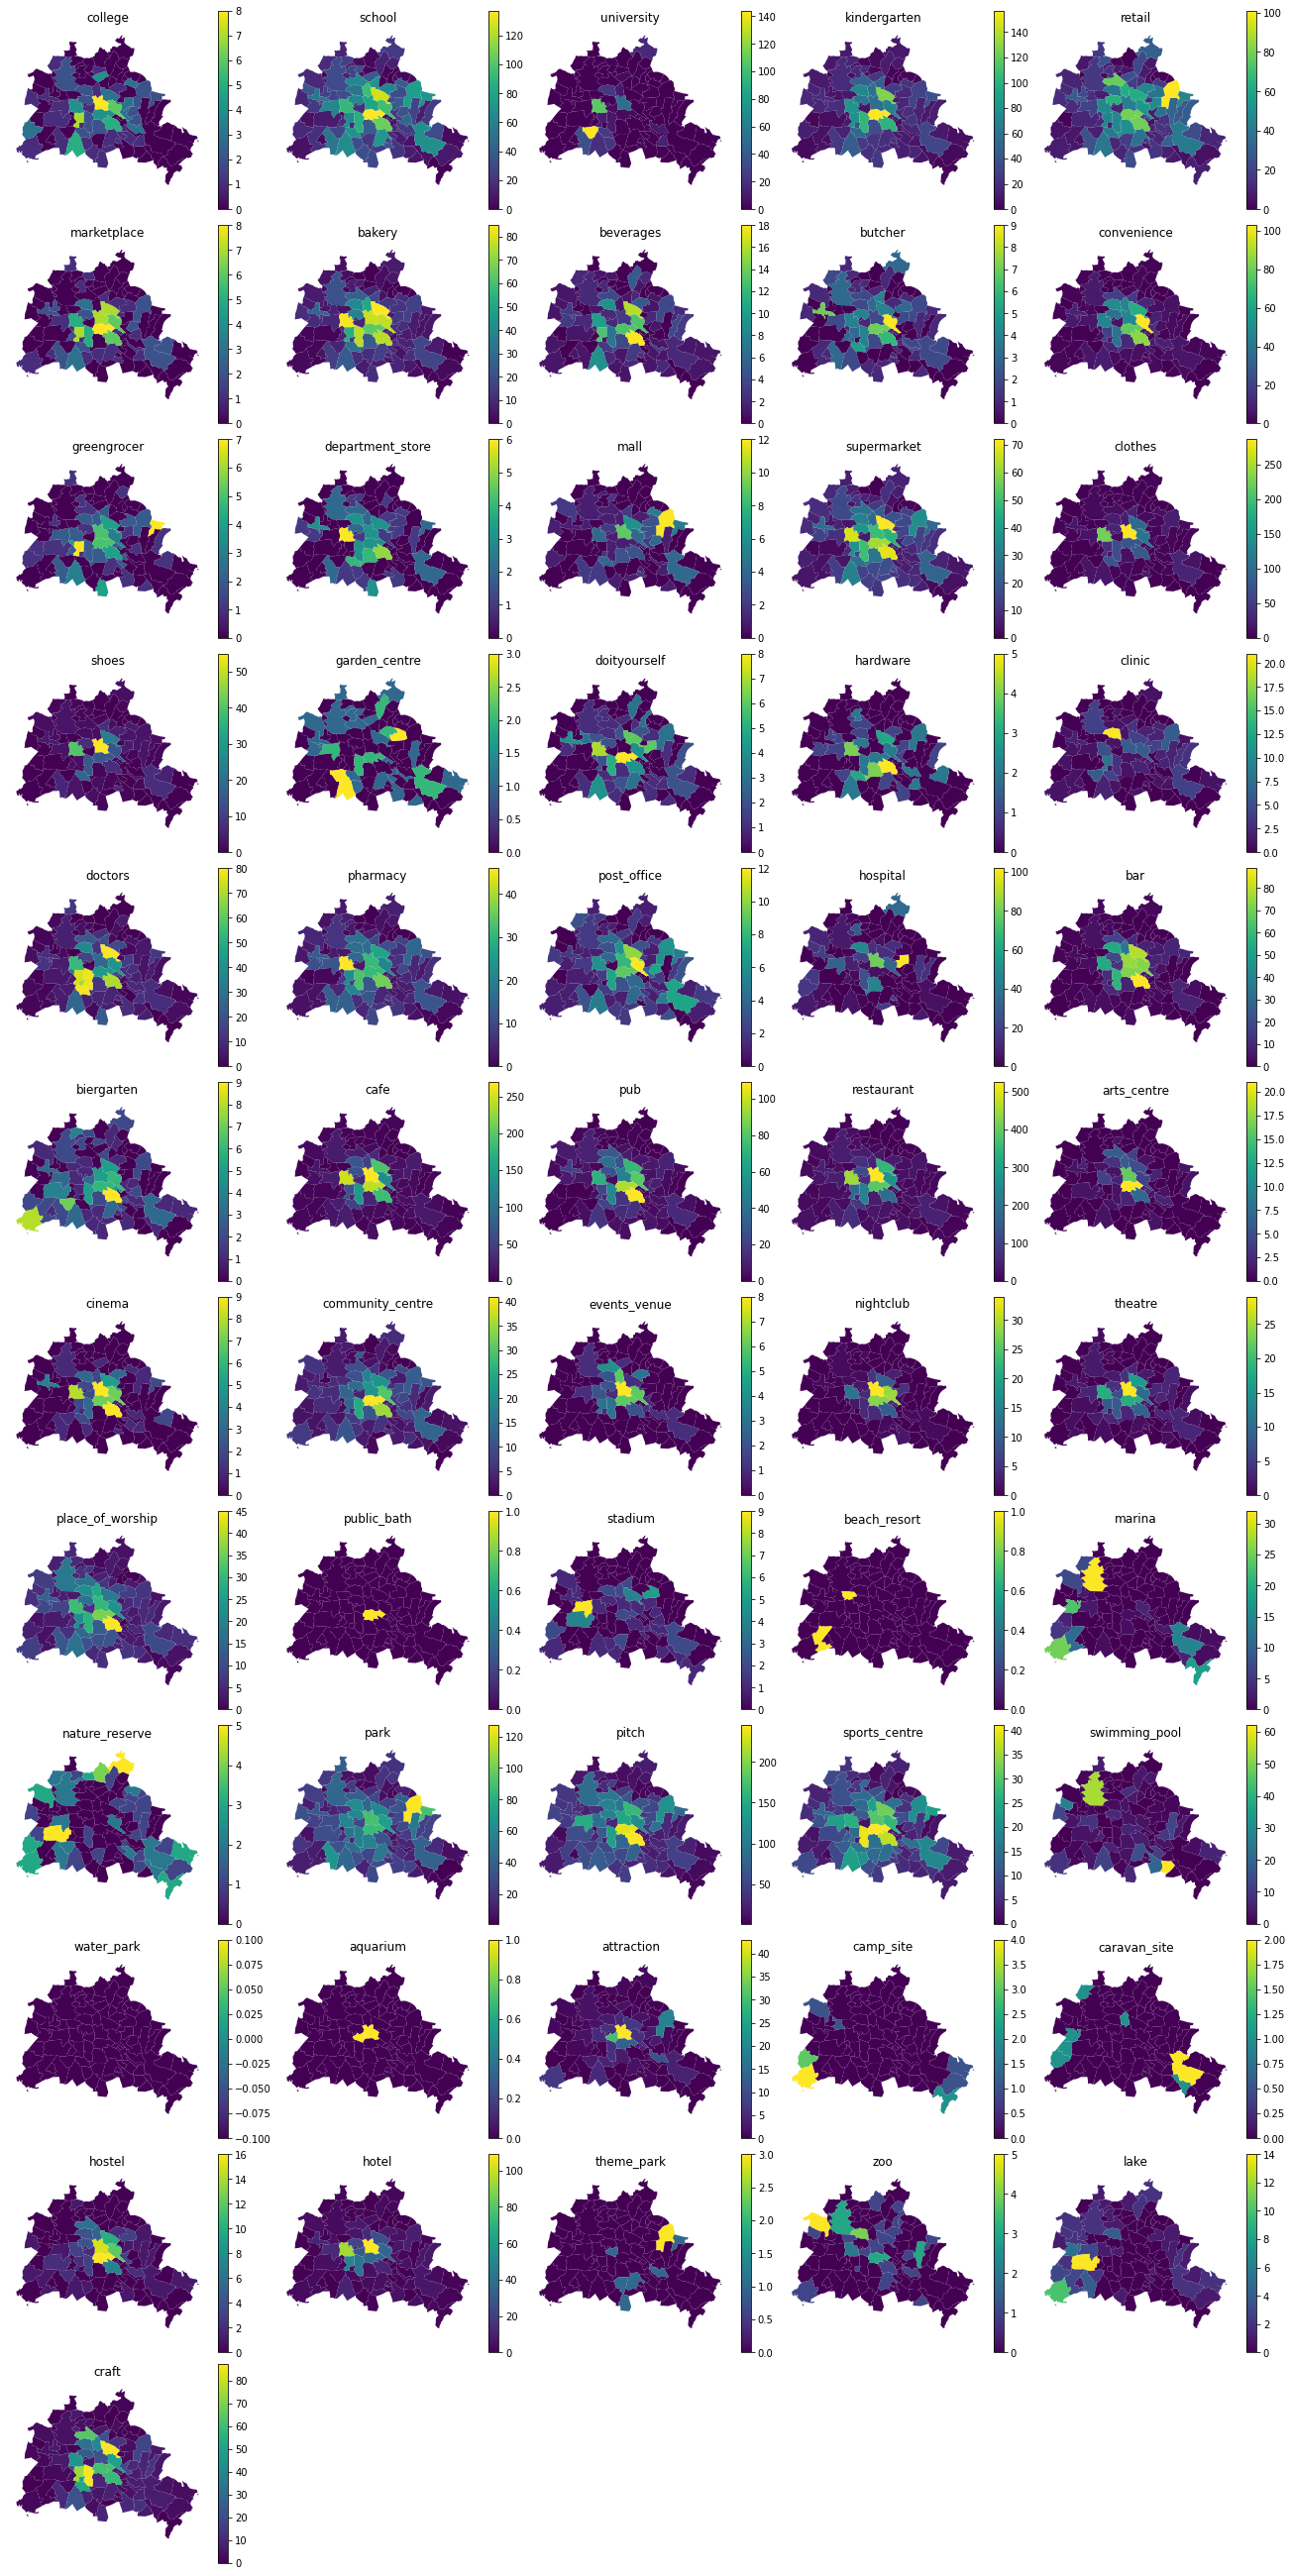

In [234]:
t0=time.time()
# Show maps for values # takes roughly 5 Minutes
clmns = poiVals + ["craft"]
ncols = 5
def ceil (n):
    return(n // 1 + 1 if(n - n // 1) else n)

nrows = int(ceil(len(clmns) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3*nrows), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for ind, clmn in enumerate(clmns):
    sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
    axs.flat[ind].set_axis_off()
    axs.flat[ind].set_title(clmn)
    helpers.printProgress(i=ind, imax=len(clmns), t=time.time(), t0=t0)

## remove empty plots
for ax in axs.flat:
    ## check if something was plotted 
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

# How to merge information into a single attractor variable

### How to weight different attractors by number of trips?

### Or possibly merge into different attractors variables categorized by how long people are willing to commute to it

### infer about modechoice by demographic characteristics?

### make sure the number of cars returning to a zone matches the number originating from it?

# How to generate OD Matrix from population and POIs

### saving

In [235]:
# Saving table
pois.to_csv(input_path + 'spatial_pois_raw.csv')

In [236]:
# Saving table
sm.zones.to_csv(input_path + 'spatial_pois_per_zone.csv')

In [237]:
# Saving model zones as geojson
sm.to_json(model_path + 'ber_zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 20.02it/s]
